MIMO
https://www.dropbox.com/sh/7ml5xw75z5jxuhk/AAAhU0BZWMJMOA0sNh0sMMS9a?dl=0

**Name:** Vivek Kumar Bharati, MTech (Communication  Engineering)

**Roll no:** 22M1081

In [ ]:
# MIMO file
import numpy as np
import numpy.linalg as nl
import numpy.random as nr
from scipy.stats import norm
from scipy.stats import unitary_group


def Dmatrix(K):
    var_nr = (10**(8/10))**2; mean_nr = 3;
    mu_nr = np.log10(mean_nr**2/np.sqrt(var_nr+mean_nr**2));
    sigma_nr = np.sqrt(np.log10(var_nr/(mean_nr**2+1)));
    nr = np.random.lognormal(mu_nr,sigma_nr,K);
    dr = np.random.randint(100,1000,K)/100;
    beta = nr/dr**3.0;
    return beta;

def DFTmat(K):
    kx, lx = np.meshgrid(np.arange(K), np.arange(K))
    omega = np.exp(-2*np.pi*1j/K)
    dftmtx = np.power(omega,kx*lx)
    return dftmtx

def Q(x):
    return 1-norm.cdf(x);

def QPSK(m,n):
    return ((2*nr.randint(2,size=(m,n))-1)+1j*(2*nr.randint(2,size=(m,n))-1))/np.sqrt(2);

def H(G):
    return np.conj(np.transpose(G));

def ArrayDictionary(G,t):
    lxx = 2/G*np.arange(G)-1;
    lx, kx = np.meshgrid(lxx, np.arange(t));
    omega = np.exp(-1j*np.pi);
    dmtx = 1/np.sqrt(t)*np.power(omega,kx*lx);
    return dmtx;

def RF_BB_matrices(numAnt,numRF,N_Beam):
    NBlk = numAnt/numRF;
    RFmat = 1/np.sqrt(numAnt)*DFTmat(numAnt);
    U = unitary_group.rvs(numRF);
    V = unitary_group.rvs(int(N_Beam/NBlk));
    CenterMat = np.concatenate((np.identity(int(N_Beam/NBlk)),
                                np.zeros((int(numRF-N_Beam/NBlk),int(N_Beam/NBlk)))),axis=0);
    BB_diag = nl.multi_dot([U,CenterMat,H(V)]);
    BBmat = np.kron(np.identity(int(NBlk)),BB_diag);
    return RFmat, BBmat

def OMP(y,Q,thrld):
    [rq,cq] = Q.shape;
    set_I = np.zeros(cq);
    r_prev = np.zeros((rq,1));
    hb_omp = np.zeros((cq,1)) + np.zeros((cq,1))*1j;
    r_curr = y;
    Qa = np.zeros((rq,cq))+ np.zeros((rq,cq))*1j;
    ix1 = 0;
    while np.absolute(nl.norm(r_prev)**2 - nl.norm(r_curr)**2) > thrld:
        m_ind = np.argmax(np.absolute(np.matmul(H(Q),r_curr)));
        set_I[ix1] = m_ind;
        Qa[:,ix1] = Q[:,m_ind];
        hb_ls = np.matmul(nl.pinv(Qa[:,0:ix1+1]),y);
        r_prev = r_curr;
        r_curr = y - np.matmul(Qa[:,0:ix1+1],hb_ls);
        ix1 = ix1 + 1;

    set_I_nz = set_I[0:ix1];
    hb_omp[set_I_nz.astype(int)] = hb_ls;
    return hb_omp

def SOMP(Opt, Dict, Ryy, numRF):
    rq, cq = np.shape(Dict);
    Res = Opt;
    RF = np.zeros((rq,numRF))+1j*np.zeros((rq,numRF));
    for iter1 in range(numRF):
        phi = nl.multi_dot([H(Dict),Ryy,Res]);
        phi_phiH = AAH(phi);
        m_ind = np.argmax(np.abs(np.diag(phi_phiH)));
        RF[:,iter1] = Dict[:,m_ind];
        RFc = RF[:,0:iter1+1];
        BB = nl.multi_dot([nl.inv(nl.multi_dot([H(RFc),Ryy,RFc])),H(RFc),Ryy,Opt]);
        Res = (Opt-np.matmul(RFc,BB))/nl.norm(Opt-np.matmul(RFc,BB));
    return  BB, RF


def SOMP_Est(y,Qbar,thrld):
    rq,cq = np.shape(Qbar);
    ry,cy = np.shape(y);
    set_I = np.zeros((cq,1));
    r_prev = np.zeros((ry,cy))+1j*np.zeros((ry,cy));
    hb_OMP = np.zeros((cq,cy))+1j*np.zeros((cq,cy));
    r_curr = y;
    Q_a = np.zeros((rq,cq))+1j*np.zeros((rq,cq));
    ix1 = 0;
    while(abs((nl.norm(r_prev,2))**2 - (nl.norm(r_curr,2))**2) > thrld):
        psi = nl.multi_dot([H(Qbar),r_curr]);
        m_ind = np.argmax(np.abs(np.diag(AAH(psi))));
        set_I[ix1] = m_ind;
        Q_a[:,ix1] = Qbar[:,m_ind];
        Q_c = Q_a[:,0:ix1+1];
        Hb_LS = np.matmul(nl.pinv(Q_c),y);
        r_prev = r_curr;
        r_curr = y - np.matmul(Q_c,Hb_LS);
        ix1 = ix1 + 1;
    set_I_nz = set_I[0:ix1];
    hb_OMP[set_I_nz.astype(int).flatten(),:] = Hb_LS;
    return hb_OMP

def MSE_time_domain(H,Ht,Fsub,r,t,Nt):
    Ht_est = np.zeros((r,t,Nt))+1j*np.zeros((r,t,Nt));
    for tx in range(t):
        for rx in range(r):
            Ht_est[rx,tx,:] = np.matmul(nl.pinv(Fsub),H[rx,tx,:]);
    MSE_td = nl.norm(Ht.flatten()-Ht_est.flatten())**2/t/r/Nt;
    return MSE_td

def SBL(y,Q,sigma_2):
    N, M = np.shape(Q);
    Gamma = np.identity(M);
    for iter in range(50):
        Sigma = nl.inv(1/sigma_2*np.matmul(H(Q),Q) + nl.inv(Gamma));
        mu = 1/sigma_2*nl.multi_dot([Sigma,H(Q),y]);
        Gamma = np.diag(np.diag(Sigma)+np.abs(mu).flatten()**2);
    return mu, Gamma



def mmWaveMIMOChannelGenerator(A_R,A_T,G,L):
    t = A_T.shape[0];
    r = A_R.shape[0];
    Psi = np.zeros(shape=(t*r,L))+np.zeros(shape=(t*r,L))*1j;
    tax = nr.choice(G, L, replace=False);
    rax = nr.choice(G, L, replace=False);
    alpha = 1/np.sqrt(2)*(nr.normal(0,1,L)+1j*nr.normal(0,1,L));
    A_T_genie = A_T[:, tax];
    A_R_genie = A_R[:, rax];
    for jx in range(L):
        Psi[:,jx] = np.kron(np.conj(A_T[:,tax[jx]]),A_R[:,rax[jx]]);
    return alpha, Psi, A_R_genie, A_T_genie


def mmWaveMIMO_OFDMChannelGenerator(A_R,A_T,L,numTaps):
    t,G = np.shape(A_T);
    r,G = np.shape(A_R);
    Ht = np.zeros((r,t,numTaps)) + 1j*np.zeros((r,t,numTaps));
    Psi = np.zeros(shape=(t*r,L))+np.zeros(shape=(t*r,L))*1j;
    tax = nr.choice(G, L, replace=False);
    rax = nr.choice(G, L, replace=False);
    A_T_genie = A_T[:, tax];
    A_R_genie = A_R[:, rax];
    for jx in range(L):
        Psi[:,jx] = np.kron(np.conj(A_T[:,tax[jx]]),A_R[:,rax[jx]]);
    for px in range(numTaps):
        alpha = 1/np.sqrt(2)*(nr.normal(0,1,L)+1j*nr.normal(0,1,L));
        Ht[:,:,px] = np.sqrt(t*r/L)*nl.multi_dot([A_R_genie,np.diag(alpha),H(A_T_genie)])
    return Ht, Psi, A_R_genie, A_T_genie



def AHA(A):
    return np.matmul(H(A),A)

def AAH(A):
    return np.matmul(A,H(A))

def mimo_capacity(Hmat, TXcov, Ncov):
    r, c = np.shape(Hmat);
    inLD = np.identity(r) + nl.multi_dot([nl.inv(Ncov),Hmat,TXcov,H(Hmat)]);
    C = np.log2(nl.det(inLD));
    return np.abs(C)


def OPT_CAP_MIMO(Heff,SNR):
    U, S, V = nl.svd(Heff, full_matrices=False)
    t = len(S);
    CAP = 0;
    while not CAP:
        onebylam = (SNR + sum(1/S[0:t]**2))/t;
        if  onebylam - 1/S[t-1]**2 >= 0:
            optP = onebylam - 1/S[0:t]**2;
            CAP = sum(np.log2(1+ S[0:t]**2 * optP));
        elif onebylam - 1/S[t-1]**2 < 0:
            t = t-1;
    return CAP

def EQ_CAP_MIMO(Heff,SNR):
    U, S, V = nl.svd(Heff, full_matrices=False)
    t = len(S);
    CAP = sum(np.log2(1+ S[0:t]**2 * SNR/t));
    return CAP


def MPAM_DECODER(EqSym,M):
    DecSym = np.round((EqSym+M-1)/2);
    DecSym[np.where(DecSym<0)] = 0;
    DecSym[np.where(DecSym>(M-1))] = M-1
    return DecSym

def MQAM_DECODER(EqSym,M):
    sqM = np.int(np.sqrt(M));
    DecSym = np.round((EqSym+sqM-1)/2);
    DecSym[np.where(DecSym<0)]=0;
    DecSym[np.where(DecSym>(sqM-1))]=sqM-1
    return DecSym

def PHYDAS(L_f,N):
    H1=0.971960;
    H2=np.sqrt(2)/2;
    H3=0.235147;
    fh=1+2*(H1+H2+H3);
    hef=np.zeros((1,L_f+1));
    for i in range(L_f+1):
        hef[0,i]=1-2*H1*np.cos(np.pi*i/(2*N))+2*H2*np.cos(np.pi*i/N)-2*H3*np.cos(np.pi*i*3/(2*N));

    hef = hef/fh;
    p_k = hef/nl.norm(hef);
    return(p_k)

def UPSAMPLE(H,k):
    m = H.shape[0];
    n = H.shape[1];
    G = np.zeros((int(m*k),n))+1j*np.zeros((int(m*k),n));
    for ix in range(m):
        G[ix*k,:] = H[ix,:];

    return(G)


def DOWNSAMPLE(H,k):
    m = H.shape[0];
    n = H.shape[1];
    G = np.zeros((int(m/k),n))+1j*np.zeros((int(m/k),n));
    for ix in range(int(m/k)):
        G[ix,:] = H[ix*k,:];

    return(G)

# Project 3: Simulating the MIMO ZF and LMMSE Receivers and plotting the BER for varying SNR

Text(0, 0.5, 'BER')

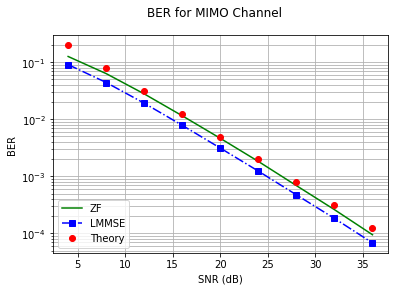

In [ ]:
# Project 3
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nr
import numpy.linalg as nl
from scipy.special import comb
import MIMO

blockLength = 1000;
nBlocks = 10000;
r = 2;
t = 2;
EbdB = np.arange(1.0,33.1,4.0);
Eb = 10**(EbdB/10);
No = 1;
Es = 2*Eb;
SNR = Es/No;
SNRdB = 10*np.log10(SNR);
BER_ZF = np.zeros(len(EbdB));
BER_LMMSE = np.zeros(len(EbdB));
BERt = np.zeros(len(EbdB));


for blk in range(nBlocks):
    H = (nr.normal(0.0, 1.0,(r,t)) + 1j*nr.normal(0.0, 1.0,(r,t)))/np.sqrt(2);
    noise = nr.normal(0.0, np.sqrt(No/2), (r,blockLength)) + 1j*nr.normal(0.0, np.sqrt(No/2), (r,blockLength));
    BitsI = nr.randint(2, size=(t, blockLength));
    BitsQ = nr.randint(2, size=(t, blockLength));
    Sym = (2*BitsI-1) +1j*(2*BitsQ-1);

    for K in range(len(SNRdB)):
        TxSym = np.sqrt(Eb[K])*Sym;
        RxSym = np.matmul(H,TxSym) + noise;

        ZFRx = nl.pinv(H);
        ZFout = np.matmul(ZFRx, RxSym);
        DecBitsI_ZF = (np.real(ZFout)>0);
        DecBitsQ_ZF = (np.imag(ZFout)>0);
        BER_ZF[K] = BER_ZF[K] + np.sum(DecBitsI_ZF != BitsI) + np.sum(DecBitsQ_ZF != BitsQ);

        LMMSERx = np.matmul(nl.inv(MIMO.AHA(H) + No*np.identity(t)/Es[K]),MIMO.H(H));
        LMMSEout = np.matmul(LMMSERx, RxSym);
        DecBitsI_LMMSE = (np.real(LMMSEout)>0);
        DecBitsQ_LMMSE = (np.imag(LMMSEout)>0);

        BER_LMMSE[K] = BER_LMMSE[K] + np.sum(DecBitsI_LMMSE != BitsI) + np.sum(DecBitsQ_LMMSE != BitsQ);


BER_ZF = BER_ZF/blockLength/nBlocks/2/t;
BER_LMMSE = BER_LMMSE/blockLength/nBlocks/2/t;
L=r-t+1;
BERt = comb(2*L-1, L)/2**L/SNR**L;

plt.yscale('log')
plt.plot(SNRdB, BER_ZF,'g-');
plt.plot(SNRdB, BER_LMMSE,'b-.s');
plt.plot(SNRdB, BERt,'ro');
plt.grid(1,which='both')
plt.suptitle('BER for MIMO Channel')
plt.legend(["ZF","LMMSE", "Theory"], loc ="lower left");
plt.xlabel('SNR (dB)')
plt.ylabel('BER')


# Project 4: plotting MIMO capacity for equal and optimal power allocation based on Waterfilling

Text(0, 0.5, 'Capacity (b/s/Hz)')

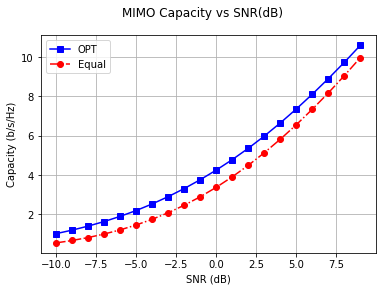

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nr
import MIMO


SNRdB = np.arange(-10,10,1);
SNR = 10**(SNRdB/10); x`);
r = 4;
t = 4;



for L in range(numBlocks):
    H = (nr.normal(0.0, 1.0,(r,t))+1j*nr.normal(0.0, 1.0,(r,t)))/np.sqrt(2)
    for kx in range(len(SNRdB)):
       Capacity_OPT[kx] = Capacity_OPT[kx] + MIMO.OPT_CAP_MIMO(H, SNR[kx]);
       Capacity_EQ[kx] += MIMO.EQ_CAP_MIMO(H, SNR[kx]);



Capacity_OPT = Capacity_OPT/numBlocks;
Capacity_EQ = Capacity_EQ/numBlocks;


plt.plot(SNRdB,Capacity_OPT,'b-s');
plt.plot(SNRdB,Capacity_EQ,'r-.o');
plt.grid(1,which='both')
plt.legend(["OPT","Equal"], loc ="upper left");
plt.suptitle('MIMO Capacity vs SNR(dB)')
plt.xlabel('SNR (dB)')
plt.ylabel('Capacity (b/s/Hz)')



**NOTE:**


1.   **Optimal power allocation** based on **Waterfilling** algorithm is the blue colourd curve.
2.   Red coloured curve is the MIMO channel capacity when equal power allocation is done.



# Project 7: Plotting the capacity of Massive MIMO channel with and without power scaling

Text(0.5, 0, 'Number of antennas M')

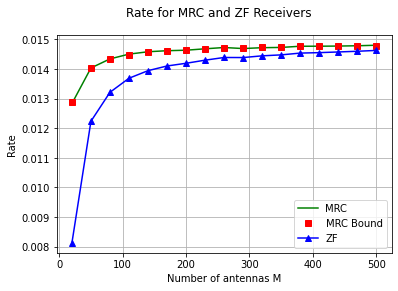

In [ ]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import matplotlib.pyplot as plt
import MIMO

ITER = 3000;
K = 10; # number of users
Mv = np.arange(20,520,30); # number of BS antennas
Eu_dB = 10;  Eu = 10**(Eu_dB/10);
rate_MRC = np.zeros(len(Mv)) ;
bound_MRC = np.zeros(len(Mv));
rate_ZF = np.zeros(len(Mv));

beta = MIMO.Dmatrix(K); # Models the large scale fading of the channel gives a log normal RV
sqrtD = np.diag(np.sqrt(beta));

for it in range(ITER):
  # print(it)
  for mx in range(len(Mv)):
    M = Mv[mx]
    #pu = Eu # no power scaling
    pu = Eu/M # power scaling
    H = (nr.normal(0, 1,(M,K)) + 1j*nr.normal(0, 1, (M,K)))/np.sqrt(2)
    G = np.matmul(H,sqrtD)  # Contains both H info and Beta info. MxK matrix
    g0 = G[:,0]; # column user 0
    MRCbf = g0/nl.norm(g0)   # beamforming vector
    nr_MRC = pu*nl.norm(g0)**2   # numerator of the SINR
    nr_bound_MRC = pu*M*beta[0]
    dr_bound_MRC = 1
    mu_int = np.matmul(MIMO.H(MRCbf), G[:,1:])  # multi user interference of all the other channels except 0
    dr_MRC = 1 + pu * nl.norm(mu_int)**2  # noise power and the interference power
    dr_bound_MRC = dr_bound_MRC + pu*np.sum(beta[1:])
    rate_MRC[mx] = rate_MRC[mx] + np.log2(1 + nr_MRC/dr_MRC)  # calculating the capacity bits/sec/Hz
    bound_MRC[mx] = bound_MRC[mx] + np.log2(1 + nr_bound_MRC/dr_bound_MRC)

    GG = np.matmul(MIMO.H(G),G)
    nr_ZF = pu
    invGG = nl.inv(GG)
    dr_ZF = np.real(invGG[0,0])
    rate_ZF[mx] = rate_ZF[mx] + np.log2(1+nr_ZF/dr_ZF)



rate_MRC = rate_MRC/ITER;
bound_MRC = bound_MRC/ITER;
rate_ZF = rate_ZF/ITER;


plt.plot(Mv, rate_MRC,'g-');
plt.plot(Mv, bound_MRC,'rs');
plt.plot(Mv, rate_ZF,'b^-');
plt.grid(1,which='both')
plt.legend(["MRC", "MRC Bound", "ZF"], loc ="lower right");
plt.suptitle('Rate for MRC and ZF Receivers')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')


Without Power scaling

Text(0.5, 0, 'Number of antennas M')

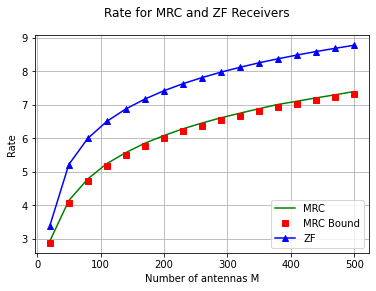

In [ ]:
plt.plot(Mv, rate_MRC,'g-');
plt.plot(Mv, bound_MRC,'rs');
plt.plot(Mv, rate_ZF,'b^-');
plt.grid(1,which='both')
plt.legend(["MRC", "MRC Bound", "ZF"], loc ="lower right");
plt.suptitle('Rate for MRC and ZF Receivers')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')

# Project 9: Plotting the rate of a user (UL rate) when the BS has imperfect knowledge of channel(i.e. the channel is estimated)

Text(0.5, 0, 'Number of antennas M')

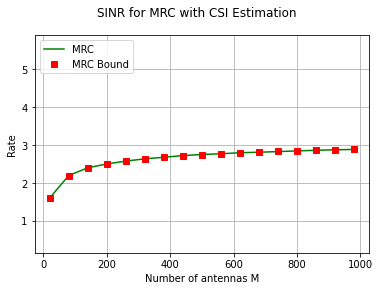

In [ ]:
import numpy as np
import numpy.linalg as nl
import numpy.random as nr
import matplotlib.pyplot as plt
import MIMO

ITER = 2000;
K = 10; # number of users
Mv = np.arange(20,1000,60); # number of BS antennas
Eu_dB = 10;  Eu = 10**(Eu_dB/10);
rate_MRC = np.zeros(len(Mv)) ;
bound_MRC = np.zeros(len(Mv));
rate_ZF = np.zeros(len(Mv));

beta = MIMO.Dmatrix(K);        # large scale fading coefficients
sqrtD = np.diag(np.sqrt(beta));

dftmtx = MIMO.DFTmat(K);

for it in range(ITER):
  # print(it)
  for mx in range(len(Mv)):
    M = Mv[mx]
    # pu = Eu # no power scaling
    # pu = Eu/M # power scaling
    pu = Eu/np.sqrt(M) # modified powerscaling
    Pp = K*pu
    H = (nr.normal(size = (M,K)) + 1j * nr.normal(size = (M,K)))/np.sqrt(2)
    G = np.matmul(H,sqrtD)  # Contains both H info and Beta info. MxK matrix
    g0 = G[:,0] # column of user 0
    Phi = np.sqrt(1/K)*dftmtx # Pilot Matrix
    N = (nr.normal(size = (M,K)) + 1j * nr.normal(size = (M,K)))/np.sqrt(2)
    RxBlk = np.sqrt(Pp)*np.matmul(G,Phi) + N # Pilot Output
    Ghat = np.sqrt(1/Pp)*np.matmul(RxBlk, MIMO.H(Phi)) # Channel Estimation
    g0hat = Ghat[:,0];
    e0 = g0hat - g0 # Channel estimation error
    nr_MRC = pu*nl.norm(g0)**2
    nr_bound_MRC = pu*M*beta[0]
    dr_bound_MRC = 1/K + (beta[0] + 1/K/pu)/beta[0]
    g0norm = g0/nl.norm(g0)
    g0hat_norm = g0hat/nl.norm(g0) # should the den be g0hat
    CSIint = np.matmul(MIMO.H(g0norm),e0)
    CSIint = pu*np.abs(CSIint)**2 # calculating the power due to channel interference error
    nint = nl.norm(g0hat)**2/nl.norm(g0)**2
    dr_MRC = CSIint + nint
    dr_bound_MRC = dr_bound_MRC + pu*np.sum((beta[0]+1/K/pu)*beta[1:]/beta[0])
    MUint = np.matmul(MIMO.H(g0hat_norm),G[:,1:])
    dr_MRC = dr_MRC + pu*nl.norm(MUint)**2
    rate_MRC[mx] = rate_MRC[mx] + np.log2(1 + nr_MRC/dr_MRC)
    bound_MRC[mx] += np.log2(1+nr_bound_MRC/dr_bound_MRC)  # Note this is the theoretical lower bound



rate_MRC = rate_MRC/ITER;
bound_MRC = bound_MRC/ITER;


plt.plot(Mv, rate_MRC,'g-');
plt.plot(Mv, bound_MRC,'rs');
plt.grid(1,which='both')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.1*y1,2*y2))
plt.legend(["MRC", "MRC Bound"], loc ="upper left");
plt.suptitle('SINR for MRC with CSI Estimation')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')

#Project 11 Spatial Modulation

Text(0, 0.5, 'BER')

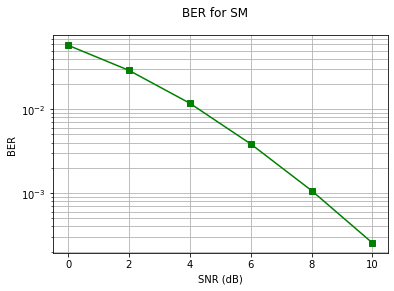

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import numpy.matlib as nm

SNRdB = np.arange(0,11,2);
ITER = 100000;
Nt = 4;
Nr = 4;
M = 2; # BPSK Modulation
bpcu = np.log2(M*Nt);
BERopt = np.zeros(len(SNRdB));
for ite in range(ITER):
  isym = nr.randint(2**bpcu)
  antIndex = isym % 4
  sym = 2 * (isym > 3) - 1
  H = 1/np.sqrt(2)*(nr.normal(0,1,(Nr,Nt)) + 1j*nr.normal(0,1,(Nr,Nt)))
  RxNoise = 1/np.sqrt(2)*(nr.normal(0,1,(Nr,1)) + 1j*nr.normal(0,1,(Nr,1)))
  for K in range(len(SNRdB)):
    rho = 10**(SNRdB[K]/10)
    RxVec = np.sqrt(rho)*H[:,antIndex:antIndex+1] * sym +RxNoise

    # Optimal detector
    MLobj = np.sum(np.absolute(np.sqrt(rho)*np.concatenate((-H,H),axis=1) - nm.repmat(RxVec, 1, 2*Nt))**2,axis=0)
    decIndex = np.argmin(MLobj)
    BERopt[K] = BERopt[K] + (decIndex != isym)

BERopt = BERopt/(bpcu*ITER);

plt.yscale('log')
plt.plot(SNRdB, BERopt,'gs-');
plt.grid(1,which='both')
plt.suptitle('BER for SM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')

#Project 13: Space Shift Keying

Text(0, 0.5, 'BER')

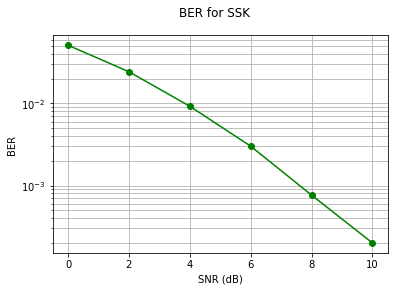

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import numpy.matlib as nm

SNRdB = np.arange(0,11,2);
ITER = 100000;
Nt = 4;
Nr = 4;
bpcu = np.log2(Nt);
BERopt = np.zeros(len(SNRdB));

for ite in range(ITER):
  antIndex = nr.randint(2**bpcu)
  H = 1/np.sqrt(2)*(nr.normal(0,1,(Nr,Nt)) + 1j*nr.normal(0,1,(Nr,Nt)))
  RxNoise = 1/np.sqrt(2)*(nr.normal(0,1,(Nr,1)) + 1j*nr.normal(0,1,(Nr,1)))
  for K in range(len(SNRdB)):
    rho = 10**(SNRdB[K]/10)
    RxVec = np.sqrt(rho)*H[:,antIndex:antIndex+1] + RxNoise

    # Optimal detector
    MLobj = np.sum(np.absolute(np.sqrt(rho)*H - nm.repmat(RxVec, 1, Nt))**2,axis=0)
    decIndex = np.argmin(MLobj)
    BERopt[K] = BERopt[K] + (decIndex != antIndex)


BERopt = BERopt/(bpcu*ITER);

plt.yscale('log')
plt.plot(SNRdB, BERopt,'go-');
plt.grid(1,which='both')
plt.suptitle('BER for SSK')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')

In [ ]:
print(antIndex)
print(H)
print(H[:,antIndex:antIndex+1])

1
[[-0.87899386+0.17141305j  0.70514466-0.93251529j  0.52559402-0.22096088j
  -1.20757375+0.20012873j]
 [-0.52152441-0.51006908j  0.10975239-0.9750905j   0.55925863-0.11845894j
   0.49027241+1.23825727j]
 [ 0.97707545-0.59815029j  1.72633855-1.24352339j -0.9131328 -0.23404121j
  -0.0886128 -0.76893363j]
 [-0.06630371+0.69811664j -0.01415723-1.53438727j -0.54800199-0.49452915j
   0.76755097+0.18413598j]]
[[ 0.70514466-0.93251529j]
 [ 0.10975239-0.9750905j ]
 [ 1.72633855-1.24352339j]
 [-0.01415723-1.53438727j]]


#Project 15: mmWave MIMO channel estimation using OMP algorithm for sparse vector estimation

Text(0.5, 0, 'SNRdB')

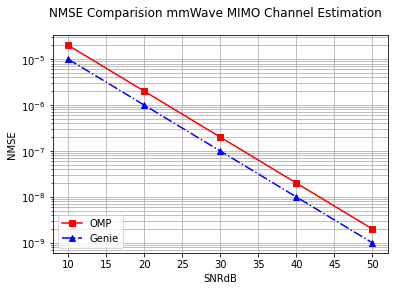

In [ ]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import matplotlib.pyplot as plt
import MIMO

t = 32; r = 32;
numRF = 8;
N_Beam = 24;       # This denotes the number of Pilot symbols For mmWave this is much smaller the t
G = 32;         # G represents the number of Angular beams (Grid Size) for efficient channel estimation G> r,t
ITER = 10;
L = 5;       # Sparsity level OR no. of multipaths

omp_thrld = 10;     # OMP threshold
SNRdB = np.arange(10,55,10);
SNR = 10**(SNRdB/10);
mseOMP = np.zeros(len(SNRdB));
mseGenie = np.zeros(len(SNRdB));

A_T = MIMO.ArrayDictionary(G,t);  # Transmit Array response Vector (size txG)
A_R = MIMO.ArrayDictionary(G,r);  # Receive Array response vector (size rxG)

FRF,FBB = MIMO.RF_BB_matrices(t,numRF,N_Beam);    # Baseband and RF Precoders
WRF,WBB = MIMO.RF_BB_matrices(r,numRF,N_Beam);    # Baseband and RF Combiners
Qtil = np.kron(np.matmul(np.transpose(FBB),np.transpose(FRF)),np.matmul(MIMO.H(WBB),MIMO.H(WRF))); # Q_tilde Kronecker Product without the pilot power

for ix in range(ITER):
  #print(ix)

  alpha , Psi, A_R_genie, A_T_genie = MIMO.mmWaveMIMOChannelGenerator(A_R,A_T,G,L) # alpha is gain, Psi is the dictionary when everything is known
  H = np.sqrt(t*r/L)*nl.multi_dot([A_R_genie,np.diag(alpha),MIMO.H(A_T_genie)])   # Channel Matrix

  ChNoise = 1/np.sqrt(t*r/L)*(nr.normal(0,1,(N_Beam,N_Beam)) + 1j*nr.normal(0,1,(N_Beam,N_Beam)))  # Channel noise of dimension N_BeamxN_Beam
  for cx in range(len(SNRdB)):                                                          # Iterating over all SNR
    Yrec = np.sqrt(SNR[cx])*nl.multi_dot([MIMO.H(WBB),MIMO.H(WRF),H,FRF,FBB]) + ChNoise     # Receive vector with known Pilot
    y = np.reshape(Yrec,(N_Beam*N_Beam,1),order = 'F')                          # Vectorising Y, stacking all columns of Y one over other. order=F =>

    Q = np.sqrt(SNR[cx])*np.matmul(Qtil,np.kron(np.conj(A_T),A_R))   # Compressed sensing matrix generated using the G vectors dictionaries
    hb_OMP = MIMO.OMP(y,Q,omp_thrld)     # beamspace sparse channel vector estimated
    H_OMP = nl.multi_dot([A_R,np.reshape(hb_OMP,(G,G),order='F'),MIMO.H(A_T)])    # H_OMP estimated channel matrix with size rxt
    mseOMP[cx] = mseOMP[cx] + nl.norm(H - H_OMP)**2/(t*r)            # Calculating mean squared error or channel estimation error H is true Channel matrix vs H_OMP which is the est. Channel Matrix

    Qbar = np.sqrt(SNR[cx])*np.matmul(Qtil,Psi)    # Compressed sensing matrix generated using the Dictionary where the angle of arrival and departure are known
    alphaEst = np.matmul(nl.pinv(Qbar),y)          # Performing the least squares estimate
    H_Genie = nl.multi_dot([A_R_genie, np.diag(alphaEst.flatten()),MIMO.H(A_T_genie)])  # 5x1 or 6x1 is considered as a matrix so diag will give just one element but we want it to be an array of 5 and give diag of 5x5 so flatten
    mseGenie[cx] = mseGenie[cx] + nl.norm(H - H_Genie)**2/(t*r)



mseOMP = mseOMP/ITER;
mseGenie = mseGenie/ITER;

plt.yscale('log')
plt.plot(SNRdB, mseOMP,'r-s');
plt.plot(SNRdB, mseGenie,'b^-.');
plt.grid(1,which='both')
plt.legend(["OMP", "Genie"], loc ="lower left");
plt.suptitle('NMSE Comparision mmWave MIMO Channel Estimation')
plt.ylabel('NMSE')
plt.xlabel('SNRdB')


#Project 17 mmWave MIMO Precoder and Combiner Design. Comparing Hybrid (SOMP) and Optimal Designs

Text(0.5, 0, 'SNRdB')

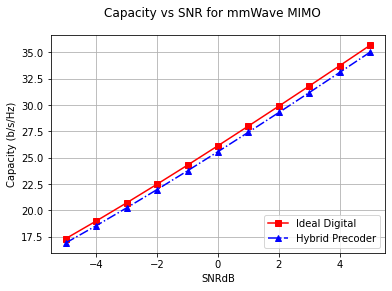

In [ ]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import matplotlib.pyplot as plt
import MIMO

# simulation parameters
t = 32; r = 32;
numRF = 6;
G = 64;
L = 8;
Ns = 6;
ITER = 100;

# Initializations
SNRdB = np.arange(-5,6,1);
C_HYB = np.zeros(len(SNRdB));
C_MIMO = np.zeros(len(SNRdB));

# G-quantized Txarray response matrix
A_T = MIMO.ArrayDictionary(G,t);
A_R = MIMO.ArrayDictionary(G,r);

for ix in range(ITER):
    # print(ix);

    # Channel generation
    tax = np.random.choice(G, L, replace=False);
    rax = np.random.choice(G, L, replace=False);
    chGain = 1/np.sqrt(2)*(nr.normal(0,1,L)+1j*nr.normal(0,1,L));
    A_T_genie = A_T[:, tax];
    A_R_genie = A_R[:, rax];
    H = np.sqrt(t*r/L)*nl.multi_dot([A_R_genie,np.diag(chGain),MIMO.H(A_T_genie)]);

    U, S, VH = nl.svd(H, full_matrices=True)

    V = MIMO.H(VH)
    Fopt = V[:,0:Ns]
    FBB, FRF = MIMO.SOMP(Fopt, A_T, np.identity(t), numRF)
    FBB_NORM = FBB*np.sqrt(Ns)/nl.norm(np.matmul(FRF,FBB))
    for cx in range(len(SNRdB)):
      npow = 10**(-SNRdB[cx]/10)
      mmseINV = nl.inv(MIMO.AHA(np.matmul(H,Fopt)) + npow*Ns*np.identity(Ns))
      Wmmse_opt = nl.multi_dot([H,Fopt,mmseINV])
      C_MIMO[cx] = C_MIMO[cx] + \
      MIMO.mimo_capacity(nl.multi_dot([MIMO.H(Wmmse_opt),H,Fopt]), 1/Ns*np.identity(Ns), npow*MIMO.AHA(Wmmse_opt))
      HFp = nl.multi_dot([H,FRF,FBB_NORM])
      Ryy = 1/Ns*MIMO.AAH(HFp) + npow*np.identity(r)
      Wmmse_Hyb = np.matmul(HFp, nl.inv(MIMO.AHA(HFp) + npow*Ns*np.identity(Ns)))
      WBB, WRF = MIMO.SOMP(Wmmse_Hyb, A_R, Ryy, numRF)
      C_HYB[cx] = C_HYB[cx] + \
      MIMO.mimo_capacity(nl.multi_dot([MIMO.H(WBB),MIMO.H(WRF),H,FRF,FBB_NORM]), 1/Ns*np.identity(Ns), npow*MIMO.AHA(np.matmul(WRF,WBB)))


C_MIMO = C_MIMO/ITER; C_HYB = C_HYB/ITER;
plt.plot(SNRdB, C_MIMO,'r-s');
plt.plot(SNRdB, C_HYB,'b^-.');
plt.grid(1,which='both')
plt.legend(["Ideal Digital", "Hybrid Precoder"], loc ="lower right");
plt.suptitle('Capacity vs SNR for mmWave MIMO')
plt.ylabel('Capacity (b/s/Hz)')
plt.xlabel('SNRdB')